In [1]:
# CELL 1: Install and Import Required Packages
!pip install ultralytics opencv-python matplotlib pillow pandas numpy seaborn


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import pandas as pd
from IPython.display import display, HTML
from ultralytics import YOLO
import time
import json

print("✓ All packages imported successfully!")

✓ All packages imported successfully!


# CELL 2: Configuration


In [3]:
MODEL_PATH = "models/best.pt" 
CONFIDENCE_THRESHOLD = 0.25
IOU_THRESHOLD = 0.45

# Dataset configuration
TEST_IMAGE_DIR = "dataset/test/images"
TEST_LABEL_DIR = "dataset/test/labels"

# Output configuration
OUTPUT_DIR = "test_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Configuration:")
print(f"  Model: {MODEL_PATH}")
print(f"  Confidence Threshold: {CONFIDENCE_THRESHOLD}")
print(f"  IOU Threshold: {IOU_THRESHOLD}")
print(f"  Test Images: {TEST_IMAGE_DIR}")
print(f"  Output: {OUTPUT_DIR}")


Configuration:
  Model: models/best.pt
  Confidence Threshold: 0.25
  IOU Threshold: 0.45
  Test Images: dataset/test/images
  Output: test_results


In [4]:
if not os.path.exists(MODEL_PATH):
    print(f"Error: Model not found at {MODEL_PATH}")
    print("Please update MODEL_PATH to point to your trained model")
else:
    # Load the trained model
    model = YOLO(MODEL_PATH)
    print(f"✓ Model loaded successfully from {MODEL_PATH}")
    
    # Display model info
    print(f"\nModel Information:")
    print(f"  Task: {model.task}")
    print(f"  Classes: {model.names}")
    print(f"  Number of parameters: {sum(p.numel() for p in model.model.parameters()):,}")

✓ Model loaded successfully from models/best.pt

Model Information:
  Task: detect
  Classes: {0: 'item'}
  Number of parameters: 25,856,899


Processing: dataset/test/images\img_00007.png

📊 Detection Statistics:
  Inference time: 732.44 ms
  Total detections: 103
  Image size: (1707, 2480)
  Confidence range: 0.512 - 0.975
  Average confidence: 0.955
✓ Saved to: test_results\single_test_result.png


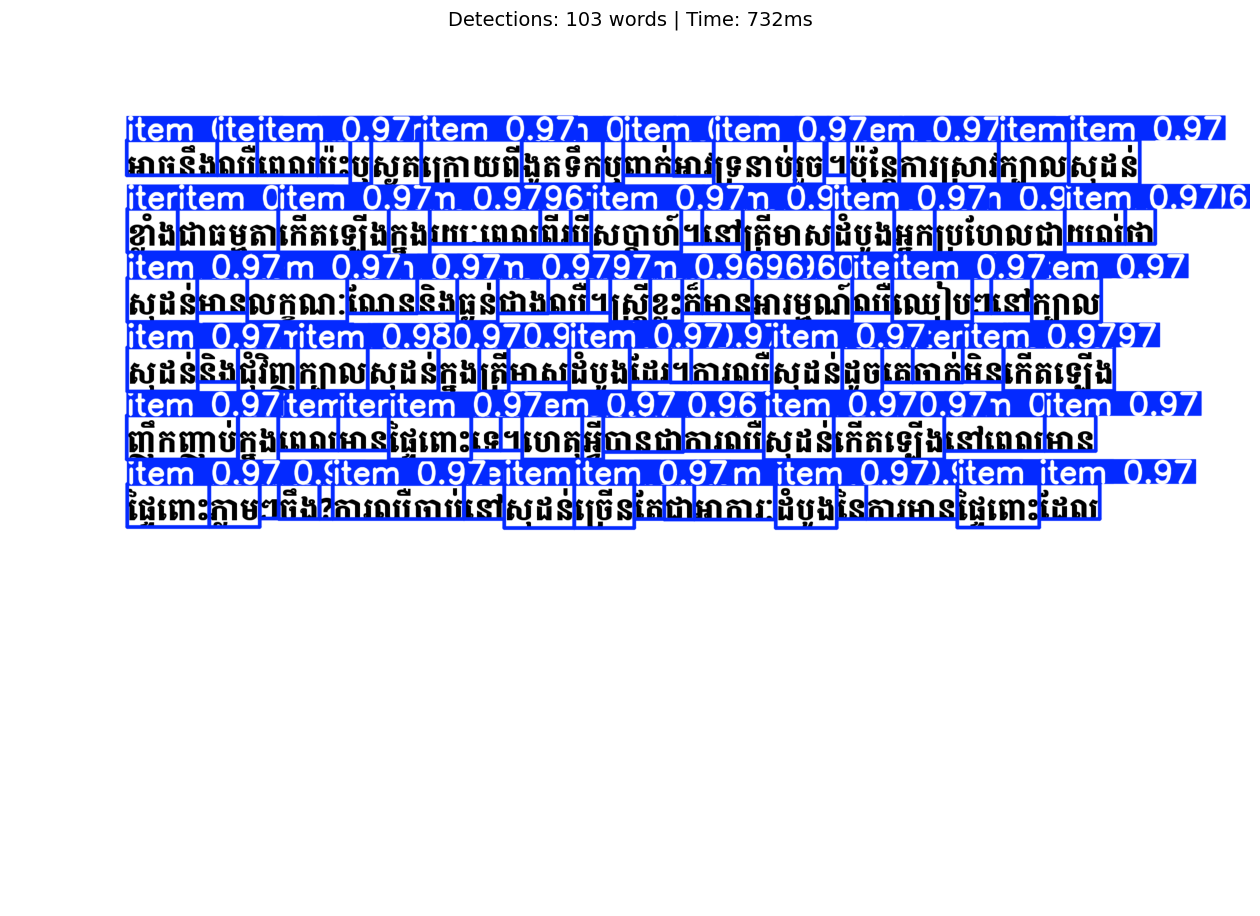


Detection Details (showing first 10):
  Box 1: Conf=0.975, BBox=[576, 590, 716, 678]
  Box 2: Conf=0.975, BBox=[1118, 590, 1240, 678]
  Box 3: Conf=0.975, BBox=[1129, 863, 1249, 951]
  Box 4: Conf=0.974, BBox=[1162, 313, 1343, 401]
  Box 5: Conf=0.974, BBox=[716, 590, 857, 679]
  Box 6: Conf=0.974, BBox=[1764, 451, 1925, 540]
  Box 7: Conf=0.974, BBox=[823, 176, 1023, 265]
  Box 8: Conf=0.974, BBox=[235, 590, 375, 678]
  Box 9: Conf=0.974, BBox=[1523, 590, 1665, 679]
  Box 10: Conf=0.974, BBox=[1645, 314, 1768, 402]
  ... and 93 more detections


In [5]:
def test_single_image(model, image_path, conf=0.25, iou=0.45, save_path=None):
    """Test model on a single image and display results"""
    
    # Check if image exists
    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        return None
    
    # Run prediction
    print(f"Processing: {image_path}")
    start_time = time.time()
    
    results = model.predict(
        source=image_path,
        conf=conf,
        iou=iou,
        verbose=False
    )
    
    inference_time = time.time() - start_time
    
    # Get results
    result = results[0]
    boxes = result.boxes
    
    # Print statistics
    print(f"\n📊 Detection Statistics:")
    print(f"  Inference time: {inference_time*1000:.2f} ms")
    print(f"  Total detections: {len(boxes)}")
    print(f"  Image size: {result.orig_shape}")
    
    if len(boxes) > 0:
        confidences = boxes.conf.cpu().numpy()
        print(f"  Confidence range: {confidences.min():.3f} - {confidences.max():.3f}")
        print(f"  Average confidence: {confidences.mean():.3f}")
    
    # Visualize results
    result_img = result.plot()
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(16, 12))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title(f'Detections: {len(boxes)} words | Time: {inference_time*1000:.0f}ms', 
              fontsize=14, pad=20)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved to: {save_path}")
    
    plt.show()
    
    # Print detailed box information
    if len(boxes) > 0:
        print(f"\nDetection Details (showing first 10):")
        for i, box in enumerate(boxes[:10]):
            conf = box.conf[0].item()
            xyxy = box.xyxy[0].cpu().numpy()
            print(f"  Box {i+1}: Conf={conf:.3f}, "
                  f"BBox=[{xyxy[0]:.0f}, {xyxy[1]:.0f}, {xyxy[2]:.0f}, {xyxy[3]:.0f}]")
        
        if len(boxes) > 10:
            print(f"  ... and {len(boxes)-10} more detections")
    
    return results

# Example: Test on a single image
# Replace with your image path
example_image = os.path.join(TEST_IMAGE_DIR, os.listdir(TEST_IMAGE_DIR)[0]) if os.path.exists(TEST_IMAGE_DIR) else None

if example_image:
    test_single_image(
        model, 
        example_image,
        conf=CONFIDENCE_THRESHOLD,
        iou=IOU_THRESHOLD,
        save_path=os.path.join(OUTPUT_DIR, 'single_test_result.png')
    )
else:
    print("No test images found. Please update TEST_IMAGE_DIR")


In [6]:
def batch_test_images(model, image_dir, conf=0.25, iou=0.45, max_images=None):
    """Test model on multiple images and collect statistics"""
    
    # Get all images
    image_files = [f for f in os.listdir(image_dir) 
                   if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    if max_images:
        image_files = image_files[:max_images]
    
    print(f"Testing on {len(image_files)} images...")
    
    results_data = []
    total_time = 0
    
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(image_dir, img_file)
        
        # Run prediction
        start_time = time.time()
        results = model.predict(source=img_path, conf=conf, iou=iou, verbose=False)
        inference_time = time.time() - start_time
        total_time += inference_time
        
        # Collect statistics
        boxes = results[0].boxes
        num_detections = len(boxes)
        
        if num_detections > 0:
            confidences = boxes.conf.cpu().numpy()
            avg_conf = confidences.mean()
            min_conf = confidences.min()
            max_conf = confidences.max()
        else:
            avg_conf = min_conf = max_conf = 0.0
        
        results_data.append({
            'image': img_file,
            'detections': num_detections,
            'avg_confidence': avg_conf,
            'min_confidence': min_conf,
            'max_confidence': max_conf,
            'inference_time_ms': inference_time * 1000
        })
        
        # Progress update
        if (i + 1) % 50 == 0:
            print(f"  Processed {i+1}/{len(image_files)} images...")
    
    # Create dataframe
    df = pd.DataFrame(results_data)
    
    # Print summary statistics
    print("\n" + "=" * 70)
    print("BATCH TEST RESULTS")
    print("=" * 70)
    print(f"\nTotal images tested: {len(image_files)}")
    print(f"Total inference time: {total_time:.2f} seconds")
    print(f"Average inference time: {total_time/len(image_files)*1000:.2f} ms/image")
    print(f"FPS: {len(image_files)/total_time:.2f}")
    
    print(f"\n Detection Statistics:")
    print(f"  Total detections: {df['detections'].sum()}")
    print(f"  Average detections per image: {df['detections'].mean():.2f}")
    print(f"  Min detections: {df['detections'].min()}")
    print(f"  Max detections: {df['detections'].max()}")
    
    print(f"\n Confidence Statistics:")
    print(f"  Average confidence: {df['avg_confidence'].mean():.3f}")
    print(f"  Min confidence: {df['min_confidence'][df['min_confidence'] > 0].min():.3f}")
    print(f"  Max confidence: {df['max_confidence'].max():.3f}")
    
    # Save results
    csv_path = os.path.join(OUTPUT_DIR, 'batch_test_results.csv')
    df.to_csv(csv_path, index=False)
    print(f"\n✓ Results saved to: {csv_path}")
    
    return df

# Run batch testing
if os.path.exists(TEST_IMAGE_DIR):
    batch_results_df = batch_test_images(
        model, 
        TEST_IMAGE_DIR,
        conf=CONFIDENCE_THRESHOLD,
        iou=IOU_THRESHOLD,
        max_images=100  # Test on first 100 images (set None for all)
    )
else:
    print(f"Test directory not found: {TEST_IMAGE_DIR}")


Testing on 15 images...

BATCH TEST RESULTS

Total images tested: 15
Total inference time: 5.60 seconds
Average inference time: 373.34 ms/image
FPS: 2.68

 Detection Statistics:
  Total detections: 2053
  Average detections per image: 136.87
  Min detections: 101
  Max detections: 172

 Confidence Statistics:
  Average confidence: 0.947
  Min confidence: 0.289
  Max confidence: 0.979

✓ Results saved to: test_results\batch_test_results.csv


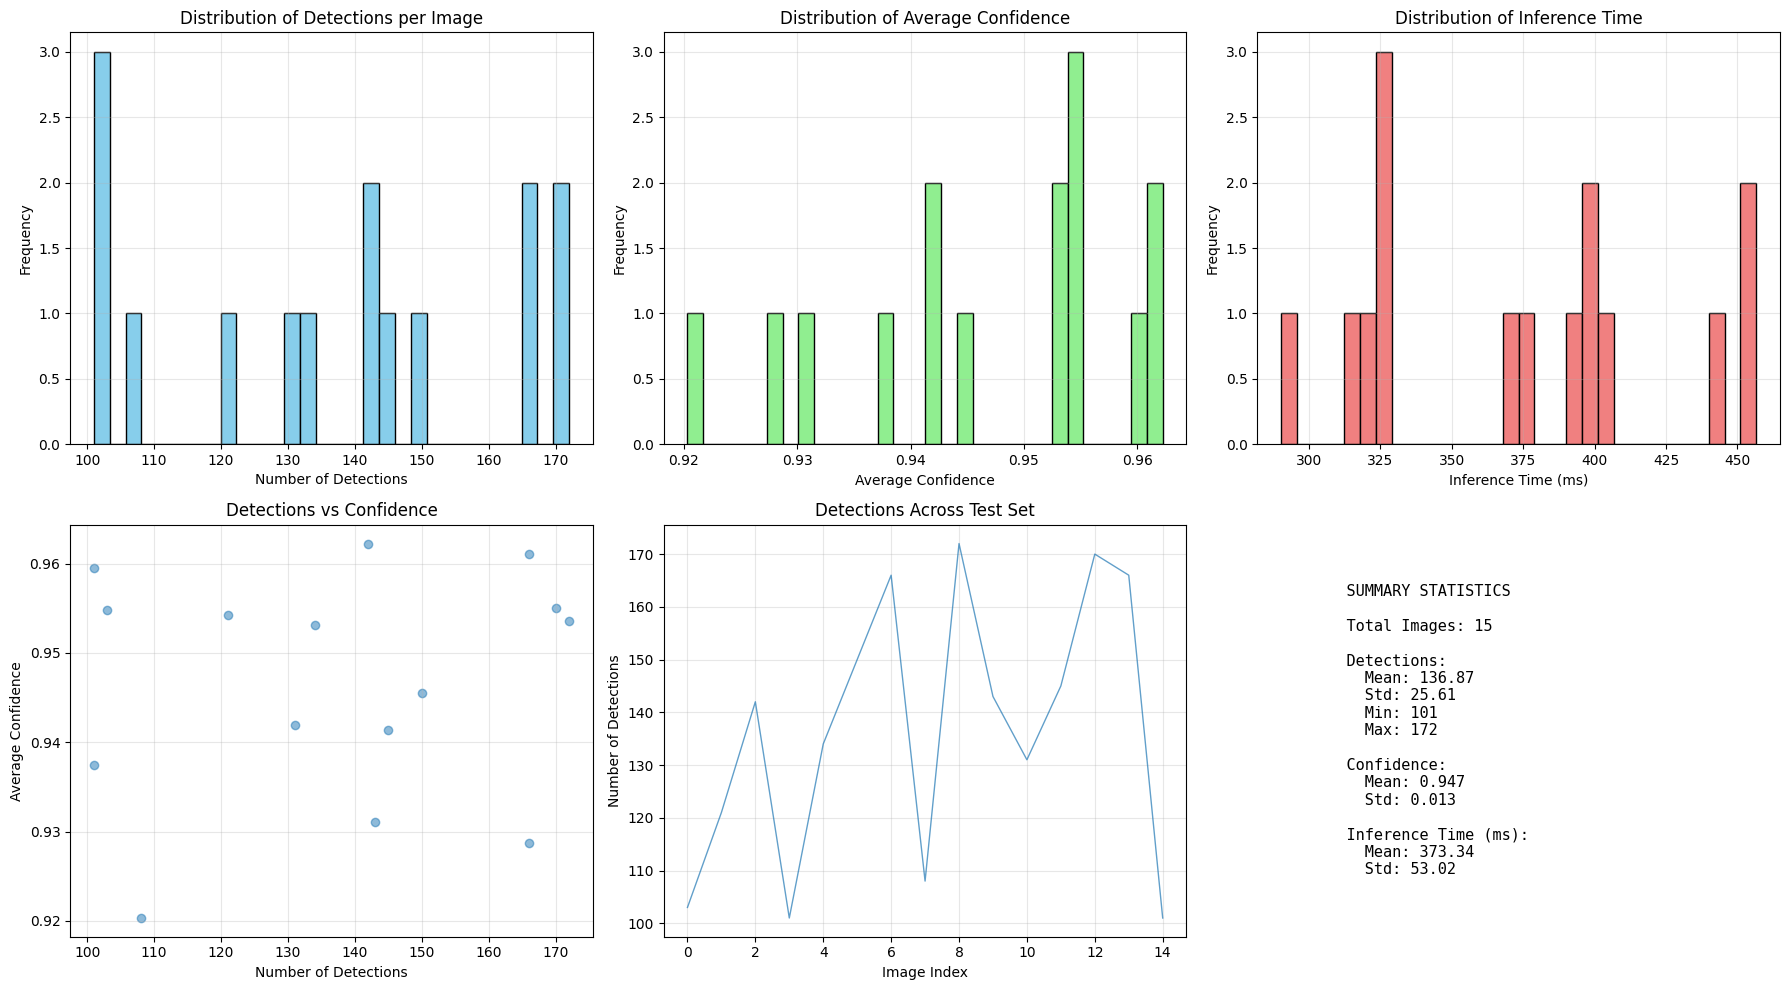

✓ Statistics plot saved to: test_results\batch_statistics.png


In [7]:
def plot_batch_statistics(df, output_dir):
    """Plot statistics from batch testing"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot 1: Detection count distribution
    axes[0, 0].hist(df['detections'], bins=30, color='skyblue', edgecolor='black')
    axes[0, 0].set_xlabel('Number of Detections')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Detections per Image')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Confidence distribution
    axes[0, 1].hist(df['avg_confidence'], bins=30, color='lightgreen', edgecolor='black')
    axes[0, 1].set_xlabel('Average Confidence')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Average Confidence')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Inference time distribution
    axes[0, 2].hist(df['inference_time_ms'], bins=30, color='lightcoral', edgecolor='black')
    axes[0, 2].set_xlabel('Inference Time (ms)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Distribution of Inference Time')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: Detections vs Confidence scatter
    axes[1, 0].scatter(df['detections'], df['avg_confidence'], alpha=0.5)
    axes[1, 0].set_xlabel('Number of Detections')
    axes[1, 0].set_ylabel('Average Confidence')
    axes[1, 0].set_title('Detections vs Confidence')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Detections over images
    axes[1, 1].plot(df.index, df['detections'], alpha=0.7, linewidth=1)
    axes[1, 1].set_xlabel('Image Index')
    axes[1, 1].set_ylabel('Number of Detections')
    axes[1, 1].set_title('Detections Across Test Set')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Summary statistics table
    axes[1, 2].axis('off')
    summary_text = f"""
    SUMMARY STATISTICS
    
    Total Images: {len(df)}
    
    Detections:
      Mean: {df['detections'].mean():.2f}
      Std: {df['detections'].std():.2f}
      Min: {df['detections'].min()}
      Max: {df['detections'].max()}
    
    Confidence:
      Mean: {df['avg_confidence'].mean():.3f}
      Std: {df['avg_confidence'].std():.3f}
    
    Inference Time (ms):
      Mean: {df['inference_time_ms'].mean():.2f}
      Std: {df['inference_time_ms'].std():.2f}
    """
    axes[1, 2].text(0.1, 0.5, summary_text, 
                    fontsize=11, family='monospace',
                    verticalalignment='center')
    
    plt.tight_layout()
    plot_path = os.path.join(output_dir, 'batch_statistics.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Statistics plot saved to: {plot_path}")

# Plot batch statistics
if 'batch_results_df' in locals():
    plot_batch_statistics(batch_results_df, OUTPUT_DIR)


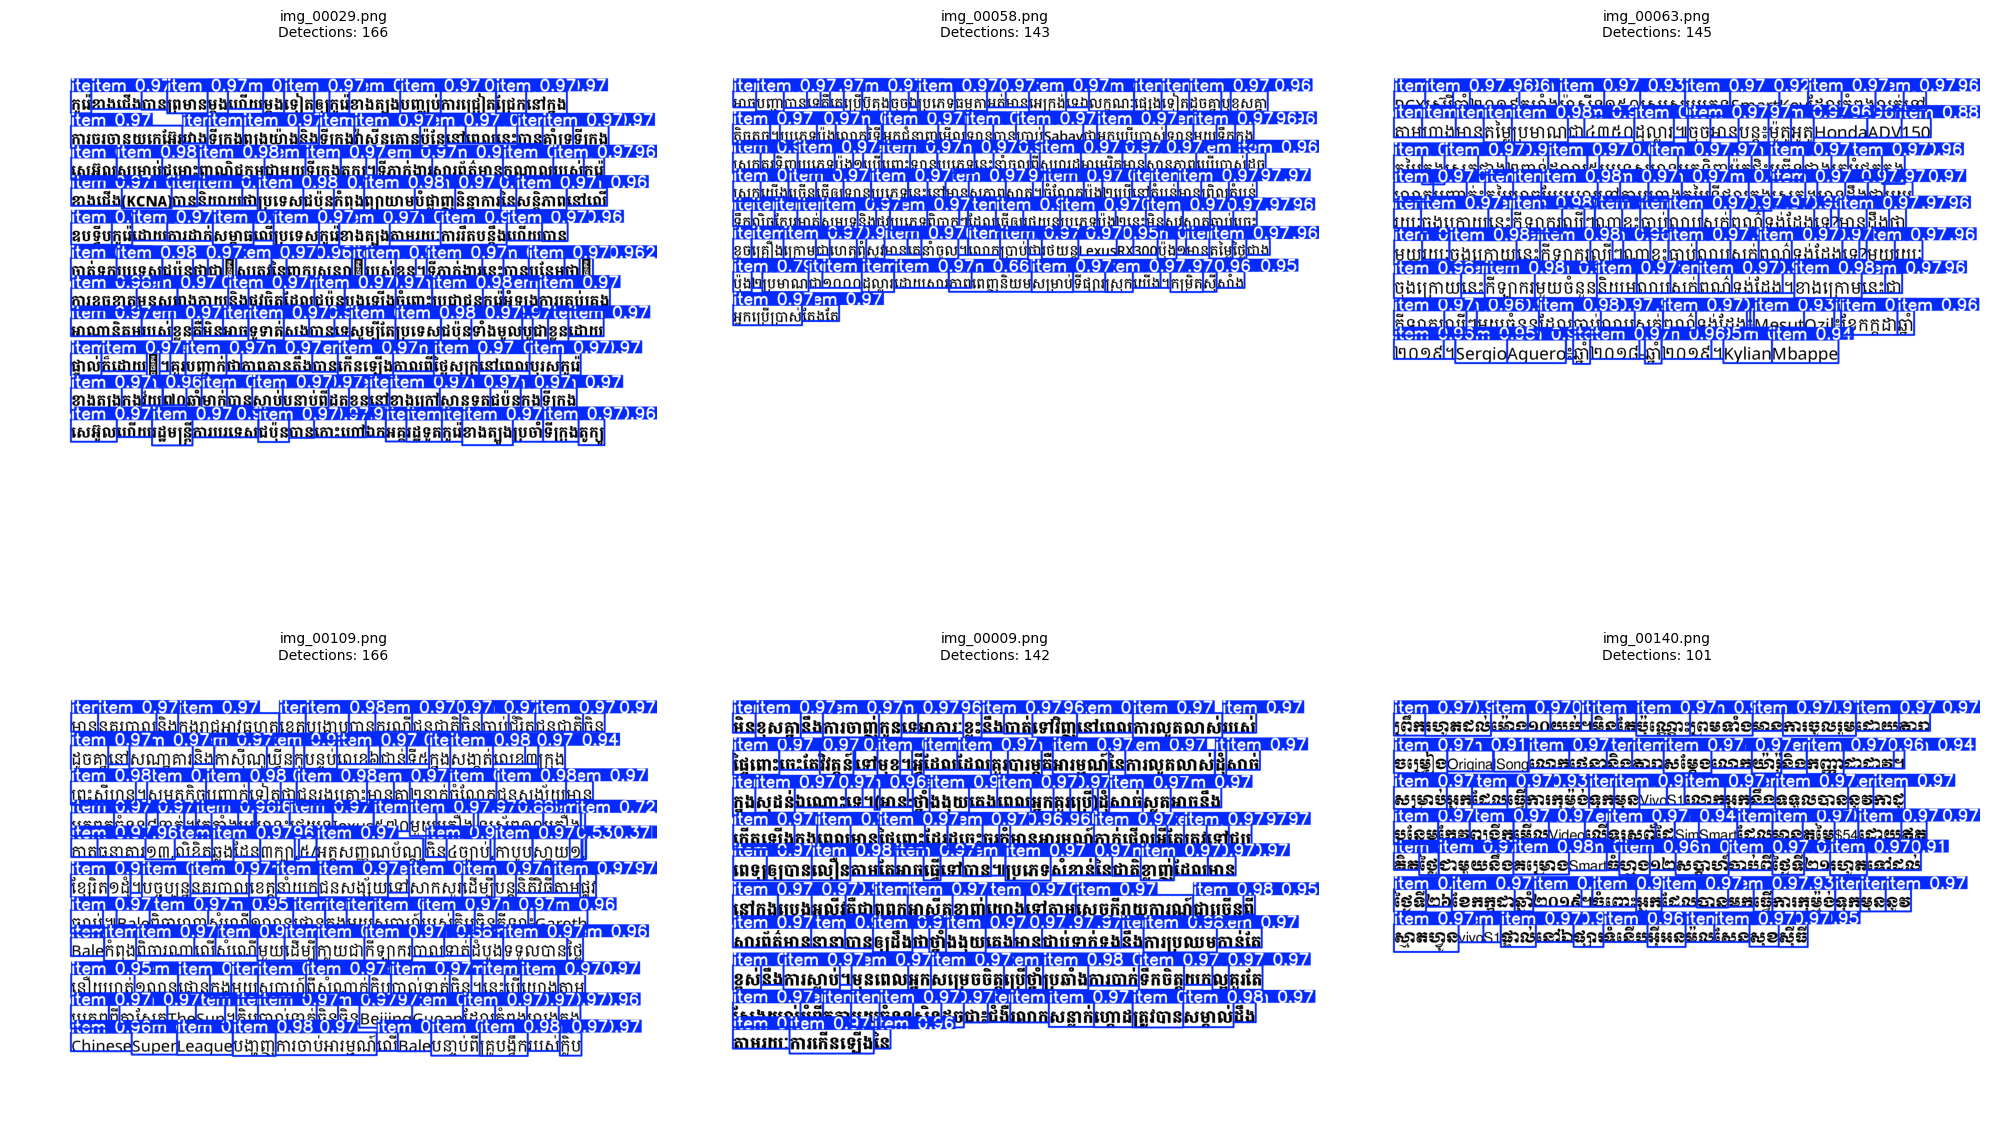

✓ Sample predictions saved to: test_results\sample_predictions.png


In [8]:
def visualize_sample_predictions(model, image_dir, conf=0.25, iou=0.45, num_samples=6):
    """Visualize predictions on random sample images"""
    
    import random
    
    # Get random images
    image_files = [f for f in os.listdir(image_dir) 
                   if f.endswith(('.png', '.jpg', '.jpeg'))]
    samples = random.sample(image_files, min(num_samples, len(image_files)))
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    axes = axes.flatten()
    
    for idx, img_file in enumerate(samples):
        img_path = os.path.join(image_dir, img_file)
        
        # Run prediction
        results = model.predict(source=img_path, conf=conf, iou=iou, verbose=False)
        result = results[0]
        
        # Plot result
        result_img = result.plot()
        result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(result_img)
        axes[idx].set_title(f'{img_file}\nDetections: {len(result.boxes)}', fontsize=10)
        axes[idx].axis('off')
    
    plt.tight_layout()
    sample_path = os.path.join(OUTPUT_DIR, 'sample_predictions.png')
    plt.savefig(sample_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Sample predictions saved to: {sample_path}")

# Visualize sample predictions
if os.path.exists(TEST_IMAGE_DIR):
    visualize_sample_predictions(
        model, 
        TEST_IMAGE_DIR,
        conf=CONFIDENCE_THRESHOLD,
        iou=IOU_THRESHOLD,
        num_samples=6
    )



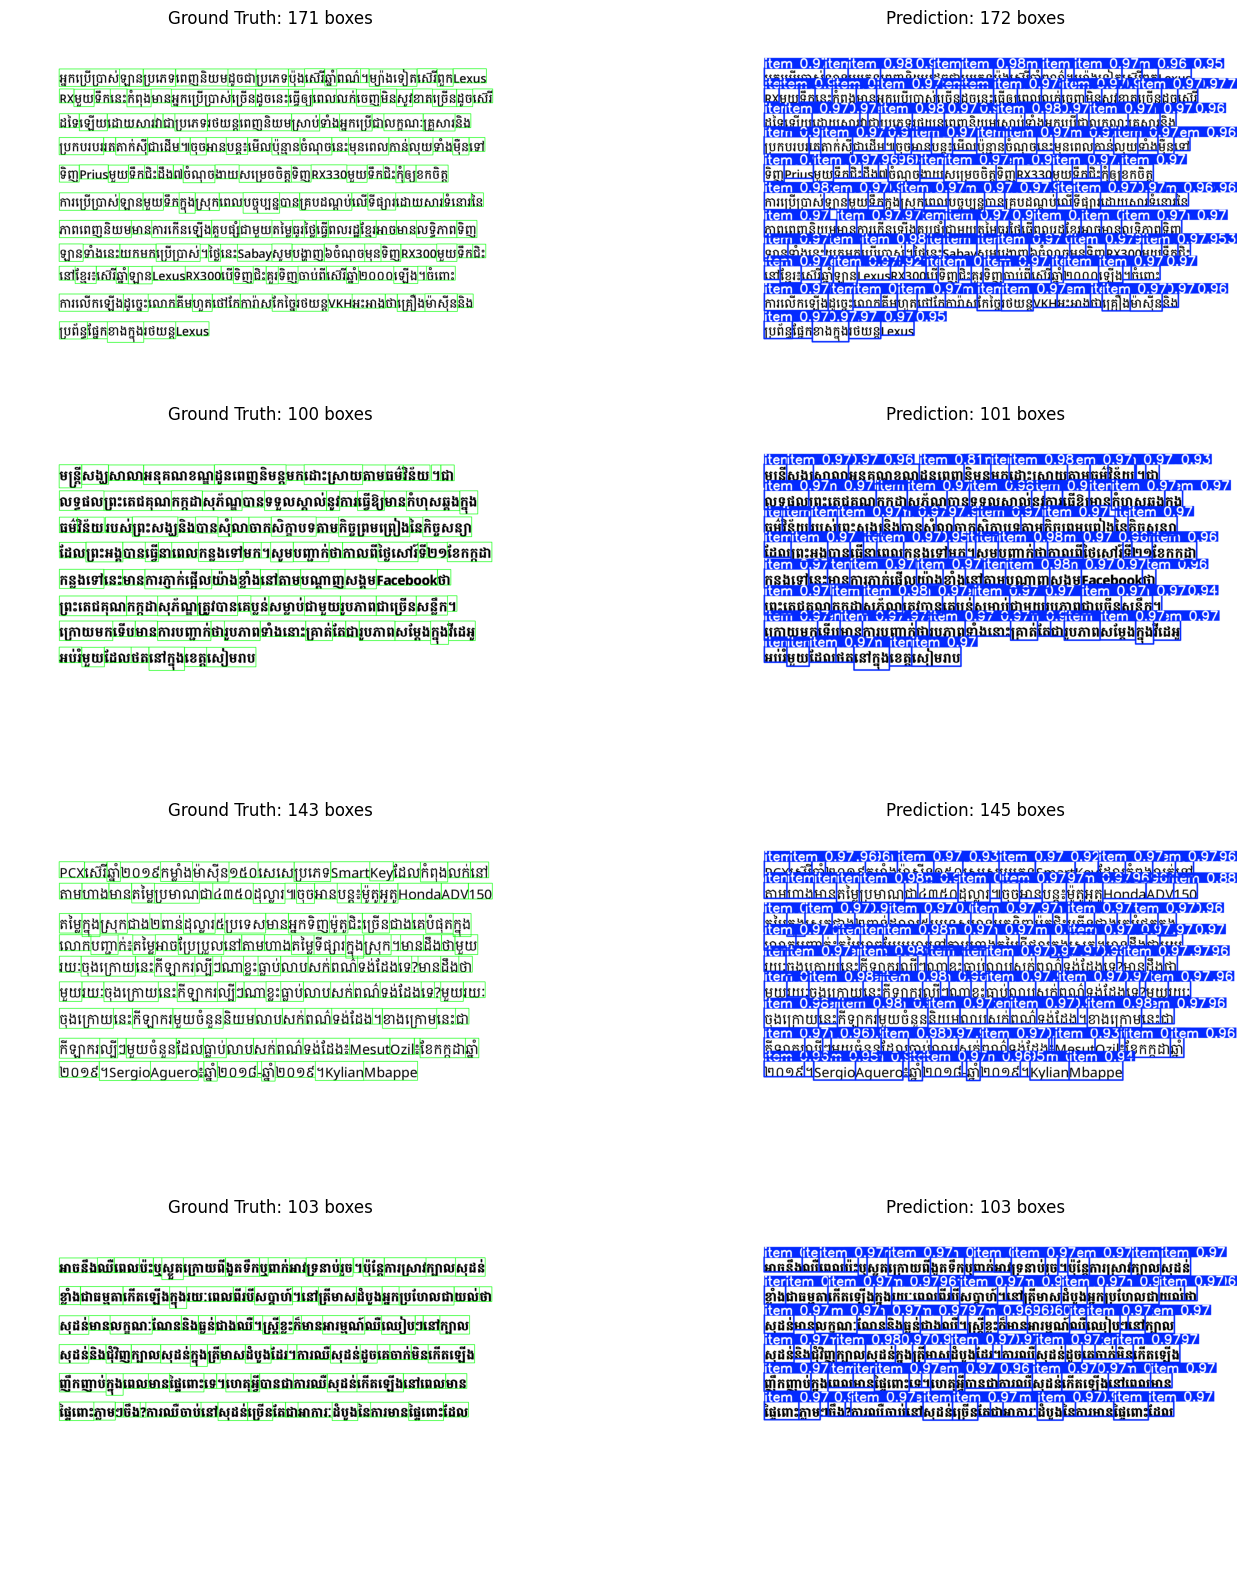

✓ Comparison saved to: test_results\ground_truth_comparison.png


In [9]:
def compare_with_ground_truth(model, image_dir, label_dir, conf=0.25, iou=0.45, num_samples=4):
    """Compare predictions with ground truth labels"""
    
    import random
    
    # Get images that have labels
    image_files = [f for f in os.listdir(image_dir) 
                   if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Filter images that have corresponding labels
    images_with_labels = []
    for img_file in image_files:
        label_file = Path(img_file).stem + '.txt'
        if os.path.exists(os.path.join(label_dir, label_file)):
            images_with_labels.append(img_file)
    
    if not images_with_labels:
        print("No images with ground truth labels found")
        return
    
    samples = random.sample(images_with_labels, min(num_samples, len(images_with_labels)))
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(16, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, img_file in enumerate(samples):
        img_path = os.path.join(image_dir, img_file)
        label_path = os.path.join(label_dir, Path(img_file).stem + '.txt')
        
        # Read image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Read ground truth
        gt_boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        _, x_center, y_center, width, height = map(float, parts[:5])
                        x1 = int((x_center - width/2) * w)
                        y1 = int((y_center - height/2) * h)
                        x2 = int((x_center + width/2) * w)
                        y2 = int((y_center + height/2) * h)
                        gt_boxes.append([x1, y1, x2, y2])
        
        # Draw ground truth
        gt_img = img_rgb.copy()
        for box in gt_boxes:
            cv2.rectangle(gt_img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        
        # Run prediction
        results = model.predict(source=img_path, conf=conf, iou=iou, verbose=False)
        pred_img = results[0].plot()
        pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
        
        # Display
        axes[idx, 0].imshow(gt_img)
        axes[idx, 0].set_title(f'Ground Truth: {len(gt_boxes)} boxes', fontsize=12)
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(pred_img)
        axes[idx, 1].set_title(f'Prediction: {len(results[0].boxes)} boxes', fontsize=12)
        axes[idx, 1].axis('off')
    
    plt.tight_layout()
    comparison_path = os.path.join(OUTPUT_DIR, 'ground_truth_comparison.png')
    plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Comparison saved to: {comparison_path}")

# Compare with ground truth
if os.path.exists(TEST_IMAGE_DIR) and os.path.exists(TEST_LABEL_DIR):
    compare_with_ground_truth(
        model,
        TEST_IMAGE_DIR,
        TEST_LABEL_DIR,
        conf=CONFIDENCE_THRESHOLD,
        iou=IOU_THRESHOLD,
        num_samples=4
    )


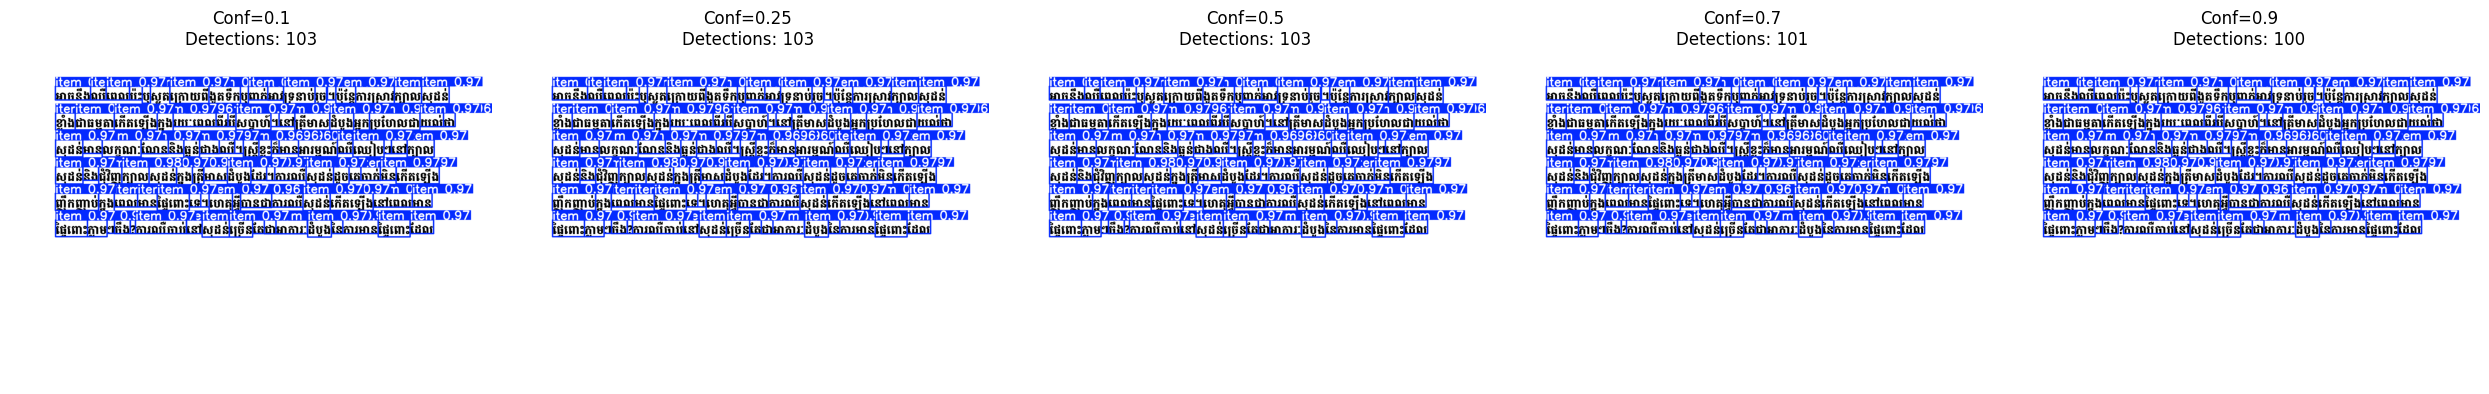

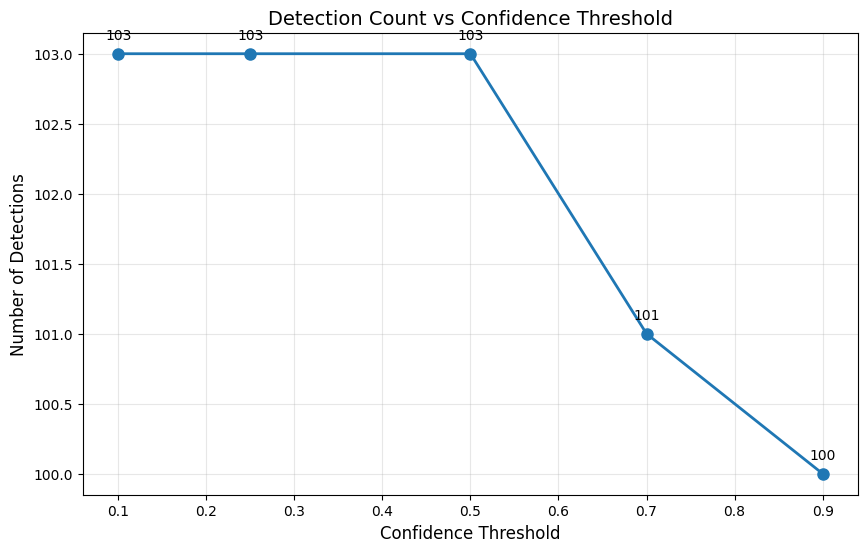

✓ Threshold analysis saved to: test_results\confidence_threshold_analysis.png
✓ Threshold curve saved to: test_results\threshold_curve.png


In [10]:
def analyze_confidence_thresholds(model, image_path, thresholds=[0.1, 0.25, 0.5, 0.7, 0.9]):
    """Analyze effect of different confidence thresholds"""
    
    fig, axes = plt.subplots(1, len(thresholds), figsize=(5*len(thresholds), 5))
    
    detection_counts = []
    
    for idx, conf_thresh in enumerate(thresholds):
        # Run prediction
        results = model.predict(source=image_path, conf=conf_thresh, verbose=False)
        result = results[0]
        
        # Plot
        result_img = result.plot()
        result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(result_img)
        axes[idx].set_title(f'Conf={conf_thresh}\nDetections: {len(result.boxes)}', fontsize=12)
        axes[idx].axis('off')
        
        detection_counts.append(len(result.boxes))
    
    plt.tight_layout()
    threshold_path = os.path.join(OUTPUT_DIR, 'confidence_threshold_analysis.png')
    plt.savefig(threshold_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Plot detection count vs threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, detection_counts, marker='o', linewidth=2, markersize=8)
    plt.xlabel('Confidence Threshold', fontsize=12)
    plt.ylabel('Number of Detections', fontsize=12)
    plt.title('Detection Count vs Confidence Threshold', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    for i, (thresh, count) in enumerate(zip(thresholds, detection_counts)):
        plt.annotate(f'{count}', 
                    xy=(thresh, count), 
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center',
                    fontsize=10)
    
    threshold_curve_path = os.path.join(OUTPUT_DIR, 'threshold_curve.png')
    plt.savefig(threshold_curve_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Threshold analysis saved to: {threshold_path}")
    print(f"✓ Threshold curve saved to: {threshold_curve_path}")

# Analyze confidence thresholds
if os.path.exists(TEST_IMAGE_DIR):
    example_image = os.path.join(TEST_IMAGE_DIR, os.listdir(TEST_IMAGE_DIR)[0])
    analyze_confidence_thresholds(
        model, 
        example_image,
        thresholds=[0.1, 0.25, 0.5, 0.7, 0.9]
    )


In [12]:
def test_custom_image(model, image_path, conf=0.25, iou=0.45):
    """Test model on a custom image with detailed output"""
    
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return
    
    print(f"Testing on: {image_path}")
    
    # Run prediction with timing
    start_time = time.time()
    results = model.predict(source=image_path, conf=conf, iou=iou, verbose=False)
    inference_time = time.time() - start_time
    
    result = results[0]
    boxes = result.boxes
    
    # Display results
    result_img = result.plot()
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(16, 12))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title(f'Custom Image Test\n'
              f'Detections: {len(boxes)} | '
              f'Inference: {inference_time*1000:.2f}ms | '
              f'Confidence: {conf}',
              fontsize=14, pad=20)
    
    custom_path = os.path.join(OUTPUT_DIR, 'custom_test_result.png')
    plt.savefig(custom_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print detailed statistics
    print(f"\n{'='*70}")
    print(f"CUSTOM IMAGE TEST RESULTS")
    print(f"{'='*70}")
    print(f"\nImage: {os.path.basename(image_path)}")
    print(f"Size: {result.orig_shape}")
    print(f"Inference time: {inference_time*1000:.2f} ms")
    print(f"Total detections: {len(boxes)}")
    
    if len(boxes) > 0:
        confidences = boxes.conf.cpu().numpy()
        print(f"\nConfidence Statistics:")
        print(f"  Min: {confidences.min():.3f}")
        print(f"  Max: {confidences.max():.3f}")
        print(f"  Mean: {confidences.mean():.3f}")
        print(f"  Median: {np.median(confidences):.3f}")
        
        print(f"\nTop 10 Detections:")
        sorted_indices = np.argsort(-confidences)[:10]
        for i, idx in enumerate(sorted_indices):
            box = boxes[idx]
            conf_val = box.conf[0].item()
            xyxy = box.xyxy[0].cpu().numpy()
            print(f"  {i+1}. Confidence: {conf_val:.3f}, "
                  f"BBox: [{xyxy[0]:.0f}, {xyxy[1]:.0f}, {xyxy[2]:.0f}, {xyxy[3]:.0f}]")
    
    print(f"\n✓ Result saved to: {custom_path}")
    print(f"{'='*70}")
    
    return results

# Test on custom image
# Uncomment and provide your image path
# test_custom_image(
#     model,
#     image_path="path/to/your/custom_image.png",
#     conf=CONFIDENCE_THRESHOLD,
#     iou=IOU_THRESHOLD
# )

print("\n" + "=" * 70)
print("✓ Testing notebook complete!")
print("=" * 70)
print(f"\nAll results saved to: {OUTPUT_DIR}/")
print(f"\nFiles generated:")
print(f"  - single_test_result.png")
print(f"  - batch_test_results.csv")
print(f"  - batch_statistics.png")
print(f"  - sample_predictions.png")
print(f"  - ground_truth_comparison.png")
print(f"  - confidence_threshold_analysis.png")
print(f"  - threshold_curve.png")



✓ Testing notebook complete!

All results saved to: test_results/

Files generated:
  - single_test_result.png
  - batch_test_results.csv
  - batch_statistics.png
  - sample_predictions.png
  - ground_truth_comparison.png
  - confidence_threshold_analysis.png
  - threshold_curve.png


In [13]:
def generate_test_report(model_path, batch_results_df, output_dir):
    """Generate a comprehensive test report"""
    
    report_path = os.path.join(output_dir, 'test_report.txt')
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("=" * 70 + "\n")
        f.write("YOLOV8 KHMER TEXT DETECTION - TEST REPORT\n")
        f.write("=" * 70 + "\n\n")
        
        f.write(f"Generated: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("MODEL INFORMATION\n")
        f.write("-" * 70 + "\n")
        f.write(f"Model Path: {model_path}\n")
        f.write(f"Confidence Threshold: {CONFIDENCE_THRESHOLD}\n")
        f.write(f"IOU Threshold: {IOU_THRESHOLD}\n\n")
        
        f.write("DATASET INFORMATION\n")
        f.write("-" * 70 + "\n")
        f.write(f"Test Images Directory: {TEST_IMAGE_DIR}\n")
        f.write(f"Total Images Tested: {len(batch_results_df)}\n\n")
        
        f.write("PERFORMANCE METRICS\n")
        f.write("-" * 70 + "\n")
        f.write(f"Average Inference Time: {batch_results_df['inference_time_ms'].mean():.2f} ms\n")
        f.write(f"Inference Time Std Dev: {batch_results_df['inference_time_ms'].std():.2f} ms\n")
        f.write(f"Min Inference Time: {batch_results_df['inference_time_ms'].min():.2f} ms\n")
        f.write(f"Max Inference Time: {batch_results_df['inference_time_ms'].max():.2f} ms\n")
        f.write(f"FPS: {1000/batch_results_df['inference_time_ms'].mean():.2f}\n\n")
        
        f.write("DETECTION STATISTICS\n")
        f.write("-" * 70 + "\n")
        f.write(f"Total Detections: {batch_results_df['detections'].sum()}\n")
        f.write(f"Average Detections per Image: {batch_results_df['detections'].mean():.2f}\n")
        f.write(f"Detection Std Dev: {batch_results_df['detections'].std():.2f}\n")
        f.write(f"Min Detections: {batch_results_df['detections'].min()}\n")
        f.write(f"Max Detections: {batch_results_df['detections'].max()}\n")
        f.write(f"Median Detections: {batch_results_df['detections'].median():.0f}\n\n")
        
        f.write("CONFIDENCE STATISTICS\n")
        f.write("-" * 70 + "\n")
        valid_conf = batch_results_df[batch_results_df['avg_confidence'] > 0]
        f.write(f"Average Confidence: {valid_conf['avg_confidence'].mean():.3f}\n")
        f.write(f"Confidence Std Dev: {valid_conf['avg_confidence'].std():.3f}\n")
        f.write(f"Min Confidence: {valid_conf['min_confidence'].min():.3f}\n")
        f.write(f"Max Confidence: {batch_results_df['max_confidence'].max():.3f}\n\n")
        
        f.write("TOP 10 IMAGES BY DETECTION COUNT\n")
        f.write("-" * 70 + "\n")
        top_10 = batch_results_df.nlargest(10, 'detections')
        for idx, row in top_10.iterrows():
            f.write(f"{row['image']:40s} - {row['detections']} detections\n")
        
        f.write("\n" + "=" * 70 + "\n")
        f.write("END OF REPORT\n")
        f.write("=" * 70 + "\n")
    
    print(f"✓ Test report saved to: {report_path}")
    return report_path

# Generate test report
if 'batch_results_df' in locals():
    generate_test_report(MODEL_PATH, batch_results_df, OUTPUT_DIR)

✓ Test report saved to: test_results\test_report.txt


In [1]:
import os
from ultralytics import YOLO
from datetime import datetime

In [6]:
MODEL_PATH = "models/best.pt"          
SOURCE = "images_test"                 
SAVE_RESULTS = True                    
SHOW = False 

In [7]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
OUTPUT_DIR = f"prediction_results_{timestamp}"

In [8]:
print("Loading YOLO model...")
model = YOLO(MODEL_PATH)

Loading YOLO model...


In [5]:
print(f"Running prediction on: {SOURCE}")

results = model.predict(
    source=SOURCE,
    save=SAVE_RESULTS,
    show=SHOW,
    project=OUTPUT_DIR,   # prediction output folder
    name="news_test",
    conf=0.25  # confidence threshold
)

print("Detection Summary:")
for r in results:
    print(r)

print("Prediction complete!")
print(f"Results saved in: {OUTPUT_DIR}/news_test")

Running prediction on: images_test

image 1/19 c:\Users\PhonSobon\OneDrive - MPTC\Documents\MPTC-AI-Engineer\khmer-segmentation\khmer-tokenzie\images_test\Khmer-Digital-Extrabold.png: 384x640 222 items, 575.7ms
image 2/19 c:\Users\PhonSobon\OneDrive - MPTC\Documents\MPTC-AI-Engineer\khmer-segmentation\khmer-tokenzie\images_test\Khmer-Digital-Extralight.png: 384x640 227 items, 348.4ms
image 3/19 c:\Users\PhonSobon\OneDrive - MPTC\Documents\MPTC-AI-Engineer\khmer-segmentation\khmer-tokenzie\images_test\Khmer-Digital-Max.png: 448x640 215 items, 433.6ms
image 4/19 c:\Users\PhonSobon\OneDrive - MPTC\Documents\MPTC-AI-Engineer\khmer-segmentation\khmer-tokenzie\images_test\Khmer-Digital-Number-Max.png: 480x640 223 items, 435.7ms
image 5/19 c:\Users\PhonSobon\OneDrive - MPTC\Documents\MPTC-AI-Engineer\khmer-segmentation\khmer-tokenzie\images_test\Khmer-Digital-Number.png: 416x640 237 items, 444.1ms
image 6/19 c:\Users\PhonSobon\OneDrive - MPTC\Documents\MPTC-AI-Engineer\khmer-segmentation\khme

In [9]:
print(f"Running prediction (BOX ONLY) on: {SOURCE}")

results = model.predict(
    source=SOURCE,
    save=SAVE_RESULTS,
    show=SHOW,
    project=OUTPUT_DIR,
    name="news_box_only",
    conf=0.25,
    hide_labels=True,      # << hide text labels
    hide_conf=True         # << hide confidence scores
)

print("Prediction Complete!")
print(f"Results saved in: {OUTPUT_DIR}/news_box_only")


Running prediction (BOX ONLY) on: images_test
WARNING 'hide_labels' is deprecated and will be removed in the future. Use 'show_labels' instead.
WARNING 'hide_conf' is deprecated and will be removed in the future. Use 'show_conf' instead.

image 1/25 c:\Users\PhonSobon\OneDrive - MPTC\Documents\MPTC-AI-Engineer\khmer-segmentation\khmer-tokenzie\images_test\Khmer-Digital-Extrabold.png: 384x640 222 items, 395.9ms
image 2/25 c:\Users\PhonSobon\OneDrive - MPTC\Documents\MPTC-AI-Engineer\khmer-segmentation\khmer-tokenzie\images_test\Khmer-Digital-Extralight.png: 384x640 227 items, 337.8ms
image 3/25 c:\Users\PhonSobon\OneDrive - MPTC\Documents\MPTC-AI-Engineer\khmer-segmentation\khmer-tokenzie\images_test\Khmer-Digital-Max.png: 448x640 215 items, 357.0ms
image 4/25 c:\Users\PhonSobon\OneDrive - MPTC\Documents\MPTC-AI-Engineer\khmer-segmentation\khmer-tokenzie\images_test\Khmer-Digital-Number-Max.png: 480x640 223 items, 394.6ms
image 5/25 c:\Users\PhonSobon\OneDrive - MPTC\Documents\MPTC-AI-E